In [15]:
from dotenv import load_dotenv

load_dotenv()

True

In [16]:
import os
from galileo.handlers.langchain import GalileoCallback
from galileo import log

os.environ["GALILEO_PROJECT"] = "customer-support-demo"
os.environ["GALILEO_LOG_STREAM"]="dev"

os.environ["LANGCHAIN_PROJECT"]="galileo-customer-support-demo"

# Create a callback handler
callback = GalileoCallback()

In [17]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [18]:
import sqlite3

conn = sqlite3.connect("chinook.db")
cursor = conn.cursor()

# Fetch all results
cursor.execute("SELECT * FROM Artist LIMIT 10;").fetchall()

[(1, 'AC/DC'),
 (2, 'Accept'),
 (3, 'Aerosmith'),
 (4, 'Alanis Morissette'),
 (5, 'Alice In Chains'),
 (6, 'Antônio Carlos Jobim'),
 (7, 'Apocalyptica'),
 (8, 'Audioslave'),
 (9, 'BackBeat'),
 (10, 'Billy Cobham')]

In [19]:
import sqlite3

def _refund(invoice_id: int | None, invoice_line_ids: list[int] | None, mock: bool = False) -> float:
    """Given an Invoice ID and/or Invoice Line IDs, delete the relevant Invoice/InvoiceLine records in the Chinook DB.

    Args:
        invoice_id: The Invoice to delete.
        invoice_line_ids: The Invoice Lines to delete.
        mock: If True, do not actually delete the specified Invoice/Invoice Lines. Used for testing purposes.

    Returns:
        float: The total dollar amount that was deleted (or mock deleted).
    """

    if invoice_id is None and invoice_line_ids is None:
        return 0.0

    # Connect to the Chinook database
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    total_refund = 0.0

    try:
        # If invoice_id is provided, delete entire invoice and its lines
        if invoice_id is not None:
            # First get the total amount for the invoice
            cursor.execute(
                """
                SELECT Total
                FROM Invoice
                WHERE InvoiceId = ?
            """,
                (invoice_id,),
            )

            result = cursor.fetchone()
            if result:
                total_refund += result[0]

            # Delete invoice lines first (due to foreign key constraints)
            if not mock:
                cursor.execute(
                    """
                    DELETE FROM InvoiceLine
                    WHERE InvoiceId = ?
                """,
                    (invoice_id,),
                )

                # Then delete the invoice
                cursor.execute(
                    """
                    DELETE FROM Invoice
                    WHERE InvoiceId = ?
                """,
                    (invoice_id,),
                )

        # If specific invoice lines are provided
        if invoice_line_ids is not None:
            # Get the total amount for the specified invoice lines
            placeholders = ",".join(["?" for _ in invoice_line_ids])
            cursor.execute(
                f"""
                SELECT SUM(UnitPrice * Quantity)
                FROM InvoiceLine
                WHERE InvoiceLineId IN ({placeholders})
            """,
                invoice_line_ids,
            )

            result = cursor.fetchone()
            if result and result[0]:
                total_refund += result[0]

            if not mock:
                # Delete the specified invoice lines
                cursor.execute(
                    f"""
                    DELETE FROM InvoiceLine
                    WHERE InvoiceLineId IN ({placeholders})
                """,
                    invoice_line_ids,
                )

        # Commit the changes
        conn.commit()

    except sqlite3.Error as e:
        # Roll back in case of error
        conn.rollback()
        raise e

    finally:
        # Close the connection
        conn.close()

    return float(total_refund)


def _lookup(
    customer_first_name: str,
    customer_last_name: str,
    customer_phone: str,
    track_name: str | None,
    album_title: str | None,
    artist_name: str | None,
    purchase_date_iso_8601: str | None,
) -> list[dict]:
    """Find all of the Invoice Line IDs in the Chinook DB for the given filters.

    Returns:
        a list of dictionaries that contain keys: {
            'invoice_line_id',
            'track_name',
            'artist_name',
            'purchase_date',
            'quantity_purchased',
            'price_per_unit'
        }
    """

    # Connect to the database
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    # Base query joining all necessary tables
    query = """
    SELECT
        il.InvoiceLineId,
        t.Name as track_name,
        art.Name as artist_name,
        i.InvoiceDate as purchase_date,
        il.Quantity as quantity_purchased,
        il.UnitPrice as price_per_unit
    FROM InvoiceLine il
    JOIN Invoice i ON il.InvoiceId = i.InvoiceId
    JOIN Customer c ON i.CustomerId = c.CustomerId
    JOIN Track t ON il.TrackId = t.TrackId
    JOIN Album alb ON t.AlbumId = alb.AlbumId
    JOIN Artist art ON alb.ArtistId = art.ArtistId
    WHERE c.FirstName = ?
    AND c.LastName = ?
    AND c.Phone = ?
    """

    # Parameters for the query
    params = [customer_first_name, customer_last_name, customer_phone]

    # Add optional filters
    if track_name:
        query += " AND t.Name = ?"
        params.append(track_name)

    if album_title:
        query += " AND alb.Title = ?"
        params.append(album_title)

    if artist_name:
        query += " AND art.Name = ?"
        params.append(artist_name)

    if purchase_date_iso_8601:
        query += " AND date(i.InvoiceDate) = date(?)"
        params.append(purchase_date_iso_8601)

    # Execute query
    cursor.execute(query, params)

    # Fetch results
    results = cursor.fetchall()

    # Convert results to list of dictionaries
    output = []
    for row in results:
        output.append(
            {
                "invoice_line_id": row[0],
                "track_name": row[1],
                "artist_name": row[2],
                "purchase_date": row[3],
                "quantity_purchased": row[4],
                "price_per_unit": row[5],
            }
        )

    # Close connection
    conn.close()

    return output

In [20]:
from typing import Literal
import json

from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.types import Command, interrupt
from tabulate import tabulate
from typing_extensions import Annotated, TypedDict

# Graph state.
class State(TypedDict):
    """Agent state."""
    messages: Annotated[list[AnyMessage], add_messages]
    followup: str | None

    invoice_id: int | None
    invoice_line_ids: list[int] | None
    customer_first_name: str | None
    customer_last_name: str | None
    customer_phone: str | None
    track_name: str | None
    album_title: str | None
    artist_name: str | None
    purchase_date_iso_8601: str | None

# Instructions for extracting the user/purchase info from the conversation.
gather_info_instructions = """You are managing an online music store that sells song tracks. \
Customers can buy multiple tracks at a time and these purchases are recorded in a database as \
an Invoice per purchase and an associated set of Invoice Lines for each purchased track.

Your task is to help customers who would like a refund for one or more of the tracks they've \
purchased. In order for you to be able refund them, the customer must specify the Invoice ID \
to get a refund on all the tracks they bought in a single transaction, or one or more Invoice \
Line IDs if they would like refunds on individual tracks.

Often a user will not know the specific Invoice ID(s) or Invoice Line ID(s) for which they \
would like a refund. In this case you can help them look up their invoices by asking them to \
specify:
- Required: Their first name, last name, and phone number.
- Optionally: The track name, artist name, album name, or purchase date.

If the customer has not specified the required information (either Invoice/Invoice Line IDs \
or first name, last name, phone) then please ask them to specify it."""

# Extraction schema, mirrors the graph state.
class PurchaseInformation(TypedDict):
    """All of the known information about the invoice / invoice lines the customer would like refunded. Do not make up values, leave fields as null if you don't know their value."""

    invoice_id: int | None
    invoice_line_ids: list[int] | None
    customer_first_name: str | None
    customer_last_name: str | None
    customer_phone: str | None
    track_name: str | None
    album_title: str | None
    artist_name: str | None
    purchase_date_iso_8601: str | None
    followup: Annotated[
        str | None,
        ...,
        "If the user hasn't enough identifying information, please tell them what the required information is and ask them to specify it.",
    ]

# Model for performing extraction.
info_llm = init_chat_model("gpt-4o-mini", callbacks=[callback]).with_structured_output(
    PurchaseInformation, method="json_schema", include_raw=True
)

# Graph node for extracting user info and routing to lookup/refund/END.
@log
async def gather_info(state: State) -> Command[Literal["lookup", "refund", END]]:
    info = await info_llm.ainvoke(
        [
            {"role": "system", "content": gather_info_instructions},
            *state["messages"],
        ]
    )
    parsed = info["parsed"]
    if any(parsed[k] for k in ("invoice_id", "invoice_line_ids")):
        goto = "refund"
    elif all(
        parsed[k]
        for k in ("customer_first_name", "customer_last_name", "customer_phone")
    ):
        goto = "lookup"
    else:
        goto = END
    update = {"messages": [info["raw"]], **parsed}
    return Command(update=update, goto=goto)

# Graph node for executing the refund.
# Note that here we inspect the runtime config for an "env" variable.
# If "env" is set to "test", then we don't actually delete any rows from our database.
# This will become important when we're running our evaluations.
@log
def refund(state: State, config: RunnableConfig) -> dict:
    # Whether to mock the deletion. True if the configurable var 'env' is set to 'test'.
    mock = config.get("configurable", {}).get("env", "prod") == "test"
    refunded = _refund(
        invoice_id=state["invoice_id"], invoice_line_ids=state["invoice_line_ids"], mock=mock
    )
    response = f"You have been refunded a total of: ${refunded:.2f}. Is there anything else I can help with?"
    return {
        "messages": [{"role": "assistant", "content": response}],
        "followup": response,
    }

# Graph node for looking up the users purchases
@log
def lookup(state: State) -> dict:
    args = (
        state[k]
        for k in (
            "customer_first_name",
            "customer_last_name",
            "customer_phone",
            "track_name",
            "album_title",
            "artist_name",
            "purchase_date_iso_8601",
        )
    )
    results = _lookup(*args)
    if not results:
        response = "We did not find any purchases associated with the information you've provided. Are you sure you've entered all of your information correctly?"
        followup = response
    else:
        response = f"Which of the following purchases would you like to be refunded for?\n\n```json{json.dumps(results, indent=2)}\n```"
        followup = f"Which of the following purchases would you like to be refunded for?\n\n{tabulate(results, headers='keys')}"
    return {
        "messages": [{"role": "assistant", "content": response}],
        "followup": followup,
        "invoice_line_ids": [res["invoice_line_id"] for res in results],
    }

# Building our graph
graph_builder = StateGraph(State)

graph_builder.add_node(gather_info)
graph_builder.add_node(refund)
graph_builder.add_node(lookup)

graph_builder.set_entry_point("gather_info")
graph_builder.add_edge("lookup", END)
graph_builder.add_edge("refund", END)

refund_graph = graph_builder.compile()

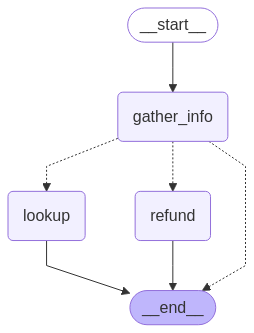

In [21]:
# Assumes you're in an interactive Python environment
from IPython.display import Image, display

display(Image(refund_graph.get_graph(xray=True).draw_mermaid_png()))

# Lookup Agent

In [22]:
from langchain.embeddings import init_embeddings
from langchain_core.tools import tool
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.prebuilt import create_react_agent

# Our SQL queries will only work if we filter on the exact string values that are in the DB.
# To ensure this, we'll create vectorstore indexes for all of the artists, tracks and albums
# ahead of time and use those to disambiguate the user input. E.g. if a user searches for
# songs by "prince" and our DB records the artist as "Prince", ideally when we query our
# artist vectorstore for "prince" we'll get back the value "Prince", which we can then
# use in our SQL queries.
def index_fields() -> tuple[InMemoryVectorStore, InMemoryVectorStore, InMemoryVectorStore]:
    """Create an index for all artists, an index for all albums, and an index for all songs."""
    try:
        # Connect to the chinook database
        conn = sqlite3.connect("chinook.db")
        cursor = conn.cursor()

        # Fetch all results
        tracks = cursor.execute("SELECT Name FROM Track").fetchall()
        artists = cursor.execute("SELECT Name FROM Artist").fetchall()
        albums = cursor.execute("SELECT Title FROM Album").fetchall()
    finally:
        # Close the connection
        if conn:
            conn.close()

    embeddings = init_embeddings("openai:text-embedding-3-small")

    track_store = InMemoryVectorStore(embeddings)
    artist_store = InMemoryVectorStore(embeddings)
    album_store = InMemoryVectorStore(embeddings)

    track_store.add_texts([t[0] for t in tracks])
    artist_store.add_texts([a[0] for a in artists])
    album_store.add_texts([a[0] for a in albums])
    return track_store, artist_store, album_store

track_store, artist_store, album_store = index_fields()

# Agent tools
@tool
@log(span_type="tool")
def lookup_track(
    track_name: str | None = None,
    album_title: str | None = None,
    artist_name: str | None = None,
) -> list[dict]:
    """Lookup a track in Chinook DB based on identifying information about.

    Returns:
        a list of dictionaries per matching track that contain keys {'track_name', 'artist_name', 'album_name'}
    """
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    query = """
    SELECT DISTINCT t.Name as track_name, ar.Name as artist_name, al.Title as album_name
    FROM Track t
    JOIN Album al ON t.AlbumId = al.AlbumId
    JOIN Artist ar ON al.ArtistId = ar.ArtistId
    WHERE 1=1
    """
    params = []

    if track_name:
        track_name = track_store.similarity_search(track_name, k=1)[0].page_content
        query += " AND t.Name LIKE ?"
        params.append(f"%{track_name}%")
    if album_title:
        album_title = album_store.similarity_search(album_title, k=1)[0].page_content
        query += " AND al.Title LIKE ?"
        params.append(f"%{album_title}%")
    if artist_name:
        artist_name = artist_store.similarity_search(artist_name, k=1)[0].page_content
        query += " AND ar.Name LIKE ?"
        params.append(f"%{artist_name}%")

    cursor.execute(query, params)
    results = cursor.fetchall()

    tracks = [
        {"track_name": row[0], "artist_name": row[1], "album_name": row[2]}
        for row in results
    ]

    conn.close()
    return tracks

@tool
@log(span_type="tool")
def lookup_album(
    track_name: str | None = None,
    album_title: str | None = None,
    artist_name: str | None = None,
) -> list[dict]:
    """Lookup an album in Chinook DB based on identifying information about.

    Returns:
        a list of dictionaries per matching album that contain keys {'album_name', 'artist_name'}
    """
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    query = """
    SELECT DISTINCT al.Title as album_name, ar.Name as artist_name
    FROM Album al
    JOIN Artist ar ON al.ArtistId = ar.ArtistId
    LEFT JOIN Track t ON t.AlbumId = al.AlbumId
    WHERE 1=1
    """
    params = []

    if track_name:
        query += " AND t.Name LIKE ?"
        params.append(f"%{track_name}%")
    if album_title:
        query += " AND al.Title LIKE ?"
        params.append(f"%{album_title}%")
    if artist_name:
        query += " AND ar.Name LIKE ?"
        params.append(f"%{artist_name}%")

    cursor.execute(query, params)
    results = cursor.fetchall()

    albums = [{"album_name": row[0], "artist_name": row[1]} for row in results]

    conn.close()
    return albums

@tool
@log(span_type="tool")
def lookup_artist(
    track_name: str | None = None,
    album_title: str | None = None,
    artist_name: str | None = None,
) -> list[str]:
    """Lookup an album in Chinook DB based on identifying information about.

    Returns:
        a list of matching artist names
    """
    conn = sqlite3.connect("chinook.db")
    cursor = conn.cursor()

    query = """
    SELECT DISTINCT ar.Name as artist_name
    FROM Artist ar
    LEFT JOIN Album al ON al.ArtistId = ar.ArtistId
    LEFT JOIN Track t ON t.AlbumId = al.AlbumId
    WHERE 1=1
    """
    params = []

    if track_name:
        query += " AND t.Name LIKE ?"
        params.append(f"%{track_name}%")
    if album_title:
        query += " AND al.Title LIKE ?"
        params.append(f"%{album_title}%")
    if artist_name:
        query += " AND ar.Name LIKE ?"
        params.append(f"%{artist_name}%")

    cursor.execute(query, params)
    results = cursor.fetchall()

    artists = [row[0] for row in results]

    conn.close()
    return artists

# Agent model
qa_llm = init_chat_model("gpt-4o-mini", callbacks=[callback])
# The prebuilt ReACT agent only expects State to have a 'messages' key, so the
# state we defined for the refund agent can also be passed to our lookup agent.
qa_graph = create_react_agent(qa_llm, [lookup_track, lookup_artist, lookup_album])

/var/folders/_y/jx3g_j6n7bl_txk7_1tfhq200000gn/T/ipykernel_91479/278090490.py:28: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  embeddings = init_embeddings("openai:text-embedding-3-small")


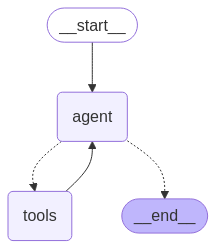

In [23]:
display(Image(qa_graph.get_graph(xray=True).draw_mermaid_png()))

# Parent Agent

In [24]:
# Schema for routing user intent.
# We'll use structured outputs to enforce that the model returns only
# the desired output.
class UserIntent(TypedDict):
    """The user's current intent in the conversation"""

    intent: Literal["refund", "question_answering"]

# Routing model with structured output
router_llm = init_chat_model("gpt-4o-mini", callbacks=[callback]).with_structured_output(
    UserIntent, method="json_schema", strict=True
)

# Instructions for routing.
route_instructions = """You are managing an online music store that sells song tracks. \
You can help customers in two types of ways: (1) answering general questions about \
tracks sold at your store, (2) helping them get a refund on a purhcase they made at your store.

Based on the following conversation, determine if the user is currently seeking general \
information about song tracks or if they are trying to refund a specific purchase.

Return 'refund' if they are trying to get a refund and 'question_answering' if they are \
asking a general music question. Do NOT return anything else. Do NOT try to respond to \
the user.
"""

# Node for routing.
async def intent_classifier(
    state: State,
) -> Command[Literal["refund_agent", "question_answering_agent"]]:
    response = router_llm.invoke(
        [{"role": "system", "content": route_instructions}, *state["messages"]]
    )
    return Command(goto=response["intent"] + "_agent")

# Node for making sure the 'followup' key is set before our agent run completes.
def compile_followup(state: State) -> dict:
    """Set the followup to be the last message if it hasn't explicitly been set."""
    if not state.get("followup"):
        return {"followup": state["messages"][-1].content}
    return {}

# Agent definition
graph_builder = StateGraph(State)
graph_builder.add_node(intent_classifier)
# Since all of our subagents have compatible state,
# we can add them as nodes directly.
graph_builder.add_node("refund_agent", refund_graph)
graph_builder.add_node("question_answering_agent", qa_graph)
graph_builder.add_node(compile_followup)

graph_builder.set_entry_point("intent_classifier")
graph_builder.add_edge("refund_agent", "compile_followup")
graph_builder.add_edge("question_answering_agent", "compile_followup")
graph_builder.add_edge("compile_followup", END)

graph = graph_builder.compile()

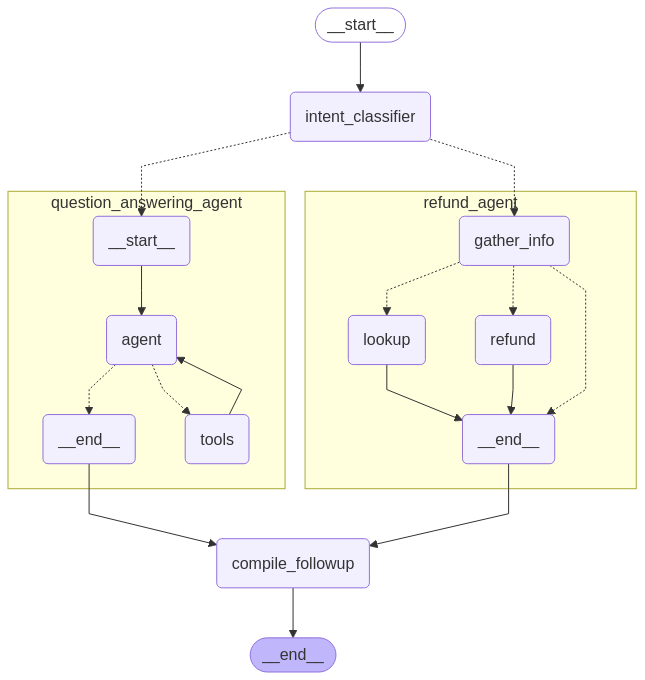

In [25]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# Test

In [26]:
state = await graph.ainvoke(
    {"messages": [{"role": "user", "content": "what james brown songs do you have"}]}
)
print(state["followup"])

Error occurred during execution: flush: 'GalileoLogger' object has no attribute '_client'
Error occurred during execution: start_trace: You must conclude the existing trace before adding a new one.


Here are some songs by James Brown:

1. **Please Please Please** - Album: Sex Machine
2. **Think** - Album: Sex Machine
3. **Night Train** - Album: Sex Machine
4. **Out Of Sight** - Album: Sex Machine
5. **Papa's Got A Brand New Bag Pt.1** - Album: Sex Machine
6. **I Got You (I Feel Good)** - Album: Sex Machine
7. **It's A Man's Man's Man's World** - Album: Sex Machine
8. **Cold Sweat** - Album: Sex Machine
9. **Say It Loud, I'm Black And I'm Proud Pt.1** - Album: Sex Machine
10. **Get Up (I Feel Like Being A) Sex Machine** - Album: Sex Machine
11. **Hey America** - Album: Sex Machine
12. **Make It Funky Pt.1** - Album: Sex Machine
13. **I'm A Greedy Man Pt.1** - Album: Sex Machine
14. **Get On The Good Foot** - Album: Sex Machine
15. **Get Up Offa That Thing** - Album: Sex Machine
16. **It's Too Funky In Here** - Album: Sex Machine
17. **Living In America** - Album: Sex Machine
18. **I'm Real** - Album: Sex Machine
19. **Hot Pants Pt.1** - Album: Sex Machine
20. **Soul Power (Live)** 